In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index
from lifelines.utils import k_fold_cross_validation


In [63]:
df = pd.read_csv("E:/DATN_LVTN/SA/CoxPH_test/processed_data.csv")
df.head()

,Age,Weight (lbs),Gender,Ethnicity,Smoking status,%GG,Tumor Location (choice=RUL),Tumor Location (choice=RML),Tumor Location (choice=RLL),Tumor Location (choice=LUL),...,EGFR mutation status,KRAS mutation status,ALK translocation status,Adjuvant Treatment,Chemotherapy,Radiation,Recurrence,Survival Status,Time to Event,Days between CT and surgery
0,79,146.0,0,2,1,0,0,1,1,1,...,1,1,1,0,0,0,0,0,3078,42
1,65,195.0,0,1,2,0,0,1,1,1,...,1,1,1,0,0,0,0,0,70,23
2,65,173.5,1,2,0,0,1,1,1,1,...,0,0,2,0,0,0,0,0,666,25
3,67,173.5,1,2,1,0,1,1,1,0,...,2,2,2,1,1,1,1,0,1172,89
4,84,145.0,1,4,1,0,1,0,1,1,...,2,1,2,0,0,0,1,1,1456,92


In [ ]:
object_cols = ['Gender', 'Ethnicity', 'Smoking status',
               '%GG', 'Tumor Location (choice=RUL)', 'Tumor Location (choice=RML)', 'Tumor Location (choice=RLL)', 'Tumor Location (choice=LUL)',
               'Tumor Location (choice=LLL)', 'Tumor Location (choice=L Lingula)', 'Tumor Location (choice=Unknown)', 'Histology',
               'Pathological T stage', 'Pathological N stage', 'Pathological M stage', 'Histopathological Grade', 'Lymphovascular invasion',
               'Pleural invasion (elastic, visceral, or parietal)', 'EGFR mutation status', 'KRAS mutation status', 'ALK translocation status', 'Adjuvant Treatment',
               'Chemotherapy', 'Radiation', 'Recurrence']

for col in object_cols:
    df[col] = np.uint8(LabelEncoder().fit_transform(df[col]))
    
df["Weight (lbs)"] = pd.to_numeric(df["Weight (lbs)"], errors="coerce")
median_weight = df["Weight (lbs)"].median()
df["Weight (lbs)"].fillna(median_weight, inplace=True)
    
df.drop(columns=["Case ID", "Patient affiliation"], inplace=True)
df.to_csv("processed_data.csv", index=False)

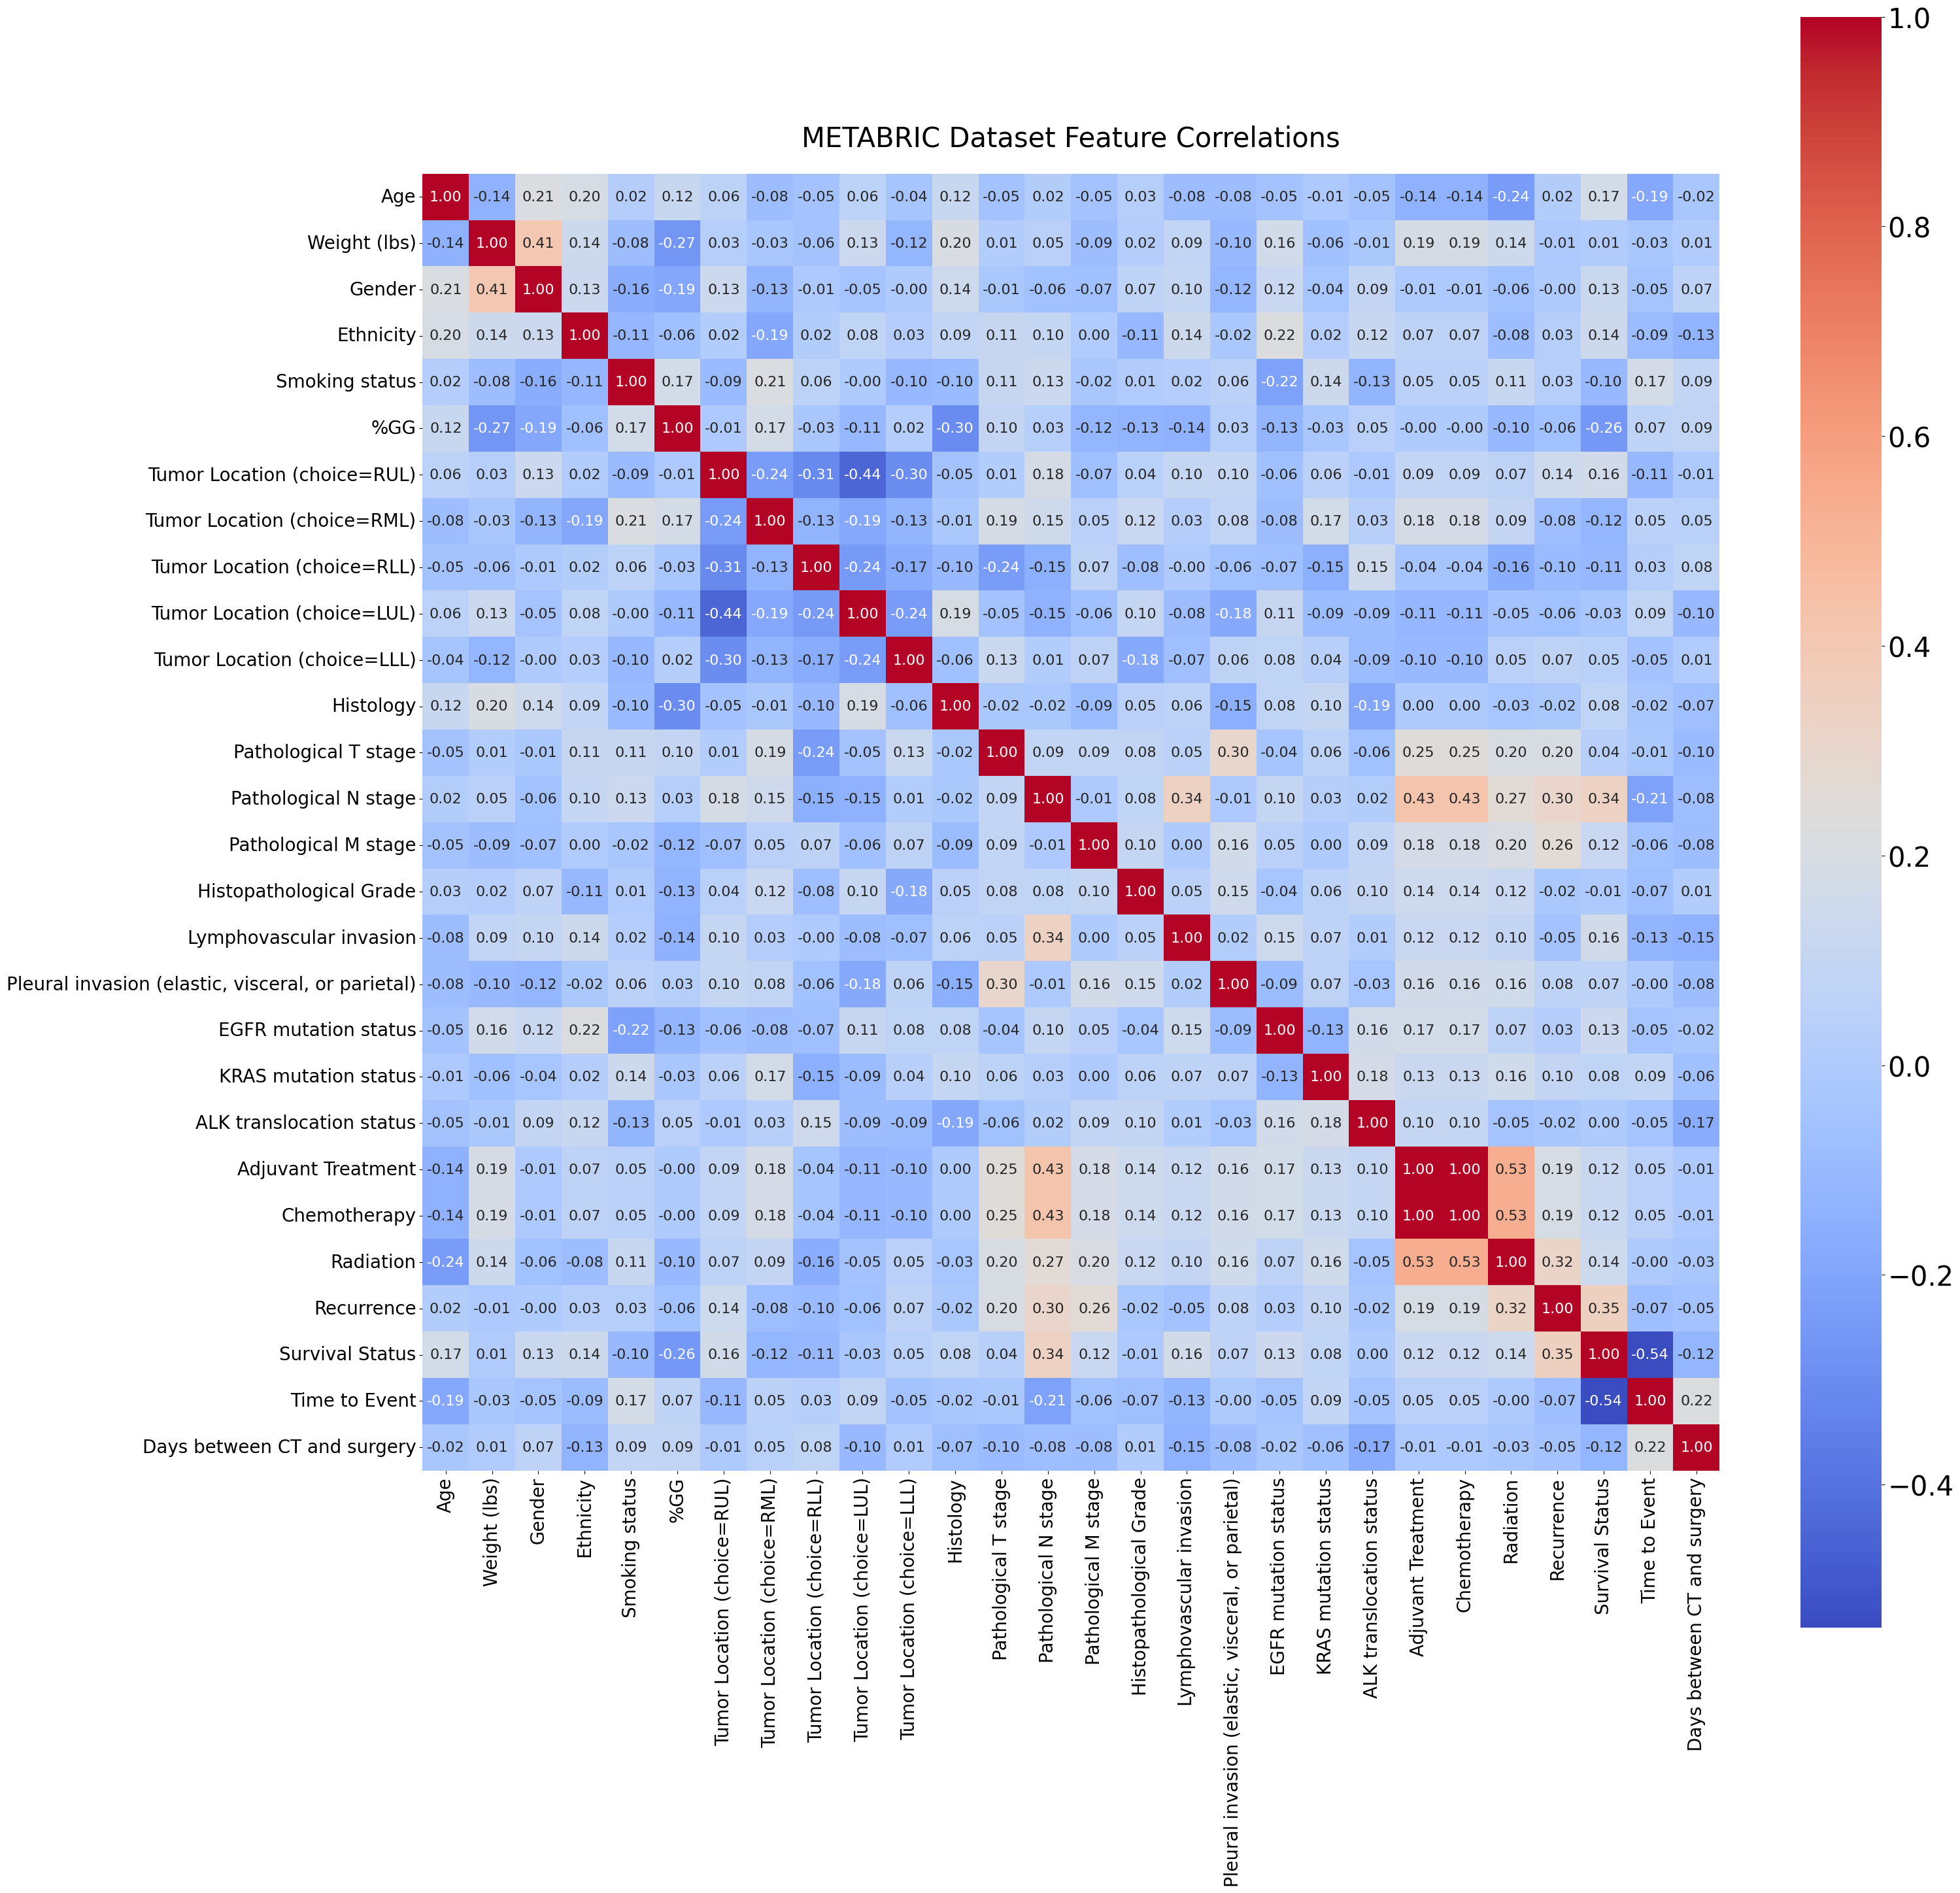

In [77]:
fig = plt.figure(figsize=(32, 32), dpi=100)

ax = sns.heatmap(df.corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 16},  fmt='.2f')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20, rotation=0)
plt.title('METABRIC Dataset Feature Correlations', size=30, pad=30)

plt.show()

In [65]:
features = [
    "Age",
    "Weight (lbs)",
    "Gender",
    "Ethnicity",
    "Smoking status",
    "%GG",
    "Tumor Location (choice=RUL)",
    "Tumor Location (choice=RML)",
    "Tumor Location (choice=RLL)",
    "Tumor Location (choice=LUL)",
    "Tumor Location (choice=LLL)",
    "Histology",
    "Pathological T stage",
    "Pathological N stage",
    "Pathological M stage",
    "Histopathological Grade",
    "Lymphovascular invasion",
    "Pleural invasion (elastic, visceral, or parietal)",
    "EGFR mutation status",
    "KRAS mutation status",
    "ALK translocation status",
    "Adjuvant Treatment",
    "Chemotherapy",
    "Radiation",
    "Recurrence",
    "Survival Status",
    "Time to Event",
    "Days between CT and surgery"
]

df_model = df[features].copy()

In [73]:
# train_df, test_df = train_test_split(df_model, test_size=0.2, stratify=df['Survival Status'], shuffle=True, random_state=0)
train_df, test_df = train_test_split(df_model, test_size=0.2, random_state=1)

# train_df.reset_index(drop=True, inplace=True)
# test_df.reset_index(drop=True, inplace=True)

# Huấn luyện mô hình trên tập train
cph = CoxPHFitter(penalizer=0.1, l1_ratio=0.5)
cph.fit(train_df, duration_col='Time to Event', event_col='Survival Status', show_progress=True)

# Đánh giá mô hình trên tập test
test_ci = cph.score(test_df, scoring_method="concordance_index")

Iteration 1: norm_delta = 1.02e+00, step_size = 0.9500, log_lik = -333.96050, newton_decrement = 1.89e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.44e-01, step_size = 0.9500, log_lik = -280.55145, newton_decrement = 5.49e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.46e-02, step_size = 0.9500, log_lik = -252.27035, newton_decrement = 3.00e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 4.45e-02, step_size = 1.0000, log_lik = -231.13121, newton_decrement = 2.90e-02, seconds_since_start = 0.0
Iteration 5: norm_delta = 4.75e-02, step_size = 1.0000, log_lik = -215.10319, newton_decrement = 3.57e-02, seconds_since_start = 0.0
Iteration 6: norm_delta = 4.99e-02, step_size = 0.9800, log_lik = -203.00805, newton_decrement = 4.27e-02, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.06e-02, step_size = 0.9604, log_lik = -193.93347, newton_decrement = 4.79e-02, seconds_since_start = 0.0
Iteration 8: norm_delta = 4.94e-02, step_size = 0.9412, log_lik = -18

In [75]:
with open('ketqua_cph.txt', 'w') as f:
    f.write("COX PROPORTIONAL HAZARDS MODEL RESULT\n")
    f.write("=" * 50 + "\n\n")
    f.write("BẢNG HỆ SỐ:\n")
    f.write(str(cph.summary) + "\n\n")
    f.write("EFFICIENCY:\n")
    f.write(f"Concordance index (train): {cph.concordance_index_:.4f}\n")
    f.write(f"Concordance index (test): {test_ci:.4f}\n\n")
    
    # Lưu hazard ratios và confidence intervals
    f.write("HAZARD RATIOS VÀ CI:\n")
    summary = cph.summary
    hazard_ratios = np.exp(summary['coef'])
    conf_intervals = np.exp(summary[['coef lower 95%', 'coef upper 95%']])
    
    for feature, hr, p_val in zip(summary.index, hazard_ratios, summary['p']):
        lower_ci = conf_intervals.loc[feature, 'coef lower 95%']
        upper_ci = conf_intervals.loc[feature, 'coef upper 95%']
        f.write(f"{feature}: HR = {hr:.3f} (95% CI: {lower_ci:.3f} - {upper_ci:.3f}), p-value = {p_val:.4f}\n")

In [76]:
k = 5  # Số lượng fold
cv_scores = k_fold_cross_validation(CoxPHFitter(penalizer=0.1, l1_ratio=0.5), 
                                   df_model, 
                                   duration_col='Time to Event', 
                                   event_col='Survival Status',
                                   k=k,
                                   scoring_method='concordance_index')

# Lưu kết quả cross-validation
with open('ketqua_cph.txt', 'a') as f:
    f.write("\nCROSS-VALIDATION RESULT:\n")
    f.write(f"Number of fold: {k}\n")
    f.write(f"Concordance indexes: {[round(score, 4) for score in cv_scores]}\n")
    f.write(f"Concordance index mean: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}\n")

# 6. Prediction trên tập test
test_df['predicted_risk'] = cph.predict_partial_hazard(test_df)
test_df['Time to Event (predicted)'] = cph.predict_expectation(test_df)

# Lưu các dự đoán vào file
test_df[['Time to Event (predicted)', 'Time to Event', 'Survival Status', 'predicted_risk']].to_csv('cph_predictions.csv', index=False)
